In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_gaussian_quantiles
from sklearn.linear_model import LogisticRegression
import copy
import numpy as np
%matplotlib inline
import random
import matplotlib.pyplot as plt

from copy import deepcopy

import csv
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor, MLPClassifier

In [3]:
def _Sample(D):
    
    DSorted = D
    
    C = []
    
    for i in range(0,len(DSorted)):
        
        C.append(sum(DSorted[0:i]))
        
    return C

In [34]:
def GBM(DataInput,depth,maxdepth,M,SamplePercent,L):
    
    # create list of learners
    LearnerList=[]
    alphalist = []
    
    Data=copy.deepcopy(DataInput)
    
    Data=np.c_[Data,np.array([1/(len(DataInput))]*(len(Data))),Data[:,2]]
    
    count = 0
    while count<=M:   
        
        #Train a weak learner on the weigthed dataset
        if L == 'NN':
            Learner = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(2,), random_state=1)
        else:
            Learner = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr')
        
        # Inverse Transform Sampling
        C = _Sample(Data[:,3])
        
        f = int(np.ceil((SamplePercent/100)*len(DataInput)))
        
        samp = f
        
        k = []
        
        elements = []

        while samp-1>=0:
            
            r = np.random.uniform(0,1,1)[0]
            ele = max(np.argwhere(C<=r))[0]
            elements.append(ele)
            samp=samp-1
        
        Learner.fit(Data[elements,0:2], Data[elements,4])
        
        #Learner.fit(Data[:,0:2], Data[:,4])
        Prediction=Learner.predict(Data[:,0:2])
        
        #Sum of weights of correctly classified points
        epsilon1 = sum(Data[:,3][np.where(Data[:,4]==Prediction)])
        
        
        #Sum of weights of incorrectly classified points
        epsilon2 = sum(Data[:,3][np.where(Data[:,4]!=Prediction)])
        
        if epsilon2 >0.5:
            continue
        
        #Calculate alpha:
        #Since the one-dimensional optimization problem to find alpha
        #has a closed form solution, we can obtain the exact solution.
        #In any case, we can always approx. the solution by taking 
        #single step of Newton-Raphson method, as suggested in FHT00
        
        #alpha = (1/2)*np.log((epsilon1)/epsilon2)  -- Exact solution
        #alpha = epsilon1-epsilon2  -- N-R approx solution
        alpha=(1/2)*np.log((epsilon1)/epsilon2)
        
        #Update weights for every data points
        for i in range(0,len(Data)):
            Data[i,3]=Data[i,3]*np.exp(-1*alpha*Data[i,4]*Prediction[i])
        
        Data[:,3]=Data[:,3]/np.sum(Data[:,3])
        
        # Append the learner at this stage to the learner list
        LearnerList.append(Learner)
        alphalist.append(alpha)
        
        count = count +1
        
    return LearnerList, alphalist

In [55]:
def plot(data, learners):
    xx = np.linspace(min(data[:,0])-0.1, max(data[:,0])+0.1, 30)
    yy = np.linspace(min(data[:,1])-0.1, max(data[:,1])+0.1, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.array(np.vstack([XX.ravel(), YY.ravel()]).T)

    pred=[0]*len(xy)
    pred=np.array(pred)
    Threshold=[0]*len(xy)
    for i in range(0,len(xy)):
        m=1
        for tree_model in learners:
            Threshold[i]=Threshold[i]+alphas[m-1]*tree_model.predict(xy[i,:].reshape(1,-1))
            
            m=m+1

        if Threshold[i]>=0:
            pred[i]=1
        else:
            pred[i]=0
    
    Z=pred.reshape(XX.shape)
    f = plt.figure(figsize=(14,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
    plt.subplot(122)
    ax2.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
    ax2.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
    plt.show()

### Boosted Neural Network

In [60]:
# Data 1
X,Y = make_circles(n_samples=100,noise=0.2, factor=0.5, random_state=1)
Data = np.append(X,Y.reshape(-1,1),axis=1)
Data[:,2][np.where(Data[:,2]==0.0)] = -1

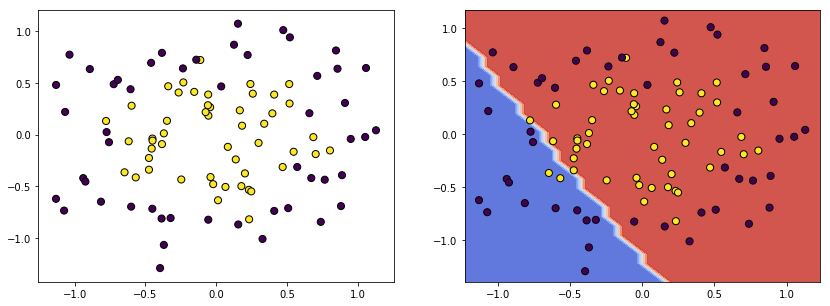

In [61]:
# Single Neural Network of 1 hidden layer and 2 hidded units
M = 1
learners, alphas = GBM(np.copy(Data),0,1,M,150,'NN')
plot(Data, learners)

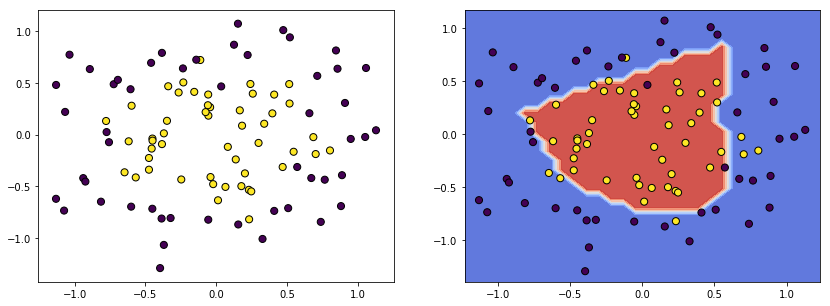

In [67]:
#Boosted ensemble of NNs
M = 50
learners, alphas = GBM(np.copy(Data),0,1,M,150,'NN')
plot(Data,learners)

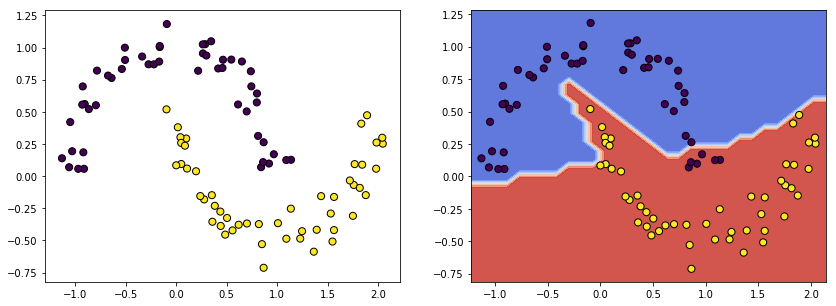

In [22]:
X,Y=make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=100)
data=np.append(X,Y.reshape(-1,1),axis=1)
data[:,2][np.where(data[:,2]==0.0)]=-1
#print(data)
M=10
learners, alphas=GBM(copy.deepcopy(data),0,1,M,90,'NN')
plot(data)

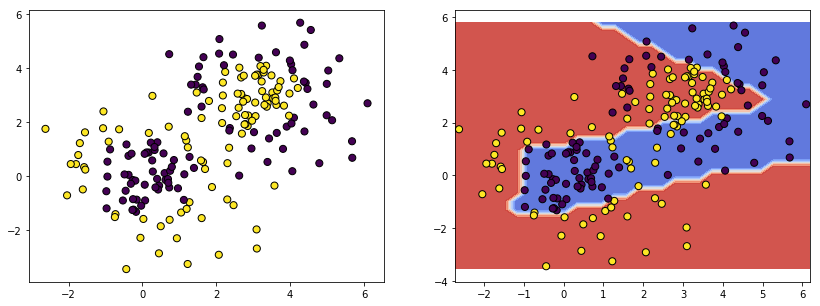

In [21]:
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=100, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=100, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
Y = np.concatenate((y1, - y2 + 1))

data=np.append(X,Y.reshape(-1,1),axis=1)
data[:,2][np.where(data[:,2]==0.0)]=-1
M=10
learners, alphas=GBM(np.copy(data),0,1,M,90)
plot(data)

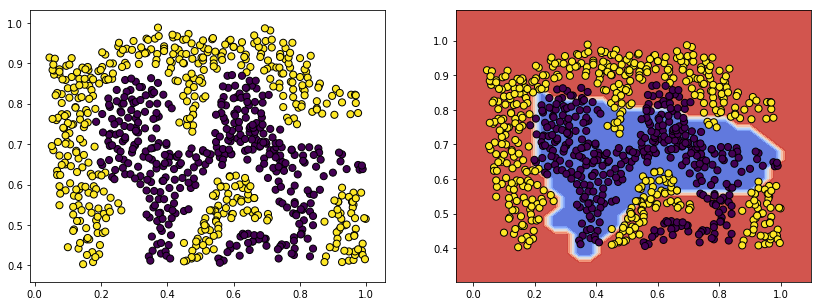

In [41]:
data_2=[]
with open("ex8a.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        data_2.append(row)
    f.close()
    
data_2=np.array(np.vstack(data_2))
data=np.ndarray.astype(data_2,float)
data[:,2][np.where(data[:,2]==0.0)]=-1
M=10
learners, alphas = GBM(np.copy(data),0,1,M,90)
plot(data)

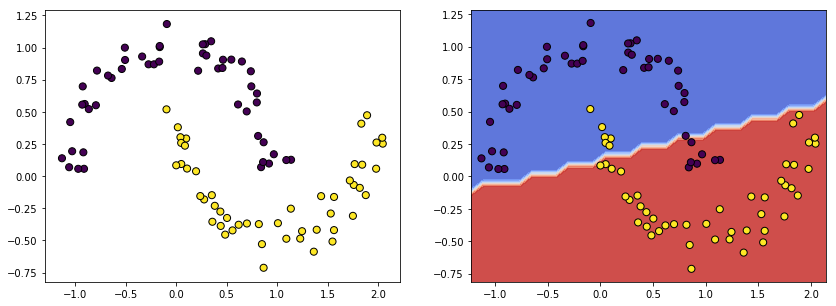

In [14]:
Learner = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(3,), random_state=1)
Learner.fit(data[:,[0,1]], data[:,2])

#pred=[0]*len(xy)
#pred=np.array(pred)
            

xx = np.linspace(min(data[:,0])-0.1, max(data[:,0])+0.1, 30)
yy = np.linspace(min(data[:,1])-0.1, max(data[:,1])+0.1, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.array(np.vstack([XX.ravel(), YY.ravel()]).T)
pred=Learner.predict(xy[:,:])
Z=pred.reshape(XX.shape)
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
plt.subplot(122)
ax2.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
ax2.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
plt.show()